### Data EDA

In [2]:
%cd ..

test  test.json  train	train.json


In [3]:
import json
import cv2
import glob
import os

In [4]:
train_imgs = glob.glob('./train/*')

In [5]:
print(len(train_imgs)) # train 폴더 파일 실 갯수

4883


In [6]:
ext_check = set()
for imgs in train_imgs:
    root, ext = os.path.splitext(imgs)
    ext_check.add(ext)
print(ext_check) # jpg만 존재

{'.jpg'}


In [7]:
with open('train.json', 'r') as f:
    json_data = json.load(f)

# 사용할 항목 'categories', 'images', 'annotations'

In [8]:
import pandas as pd
from pandas import json_normalize
import numpy as np
from PIL import Image

In [9]:
df_images = json_normalize(json_data['images'])
print(df_images.head())

   width  height       file_name  license flickr_url coco_url  \
0   1024    1024  train/0000.jpg        0       None     None   
1   1024    1024  train/0001.jpg        0       None     None   
2   1024    1024  train/0002.jpg        0       None     None   
3   1024    1024  train/0003.jpg        0       None     None   
4   1024    1024  train/0004.jpg        0       None     None   

         date_captured  id  
0  2020-12-26 14:44:23   0  
1  2021-01-10 16:30:39   1  
2  2020-12-27 17:55:52   2  
3  2021-03-31 12:10:36   3  
4  2021-01-01 18:52:38   4  


In [10]:
image_widths = df_images['width']
image_heights = df_images['height']
images_file_names = df_images['file_name']

# 모든 이미지 사이즈가 1024임
print('image max - width', np.max(image_widths), 'image max - height', np.max(image_heights))
print('image min - width', np.min(image_widths), 'image min - height', np.min(image_heights))
print('image average - width', np.mean(image_widths), 'image average - height', np.mean(image_heights))

image max - width 1024 image max - height 1024
image min - width 1024 image min - height 1024
image average - width 1024.0 image average - height 1024.0


In [11]:
# 실제 데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집
img_info = dict(heights=[], widths=[], means=[], stds=[])
for path in glob.glob(os.path.join('train', '*')):
    img = np.array(Image.open(path))
    h, w, _ = img.shape
    img_info['heights'].append(h)
    img_info['widths'].append(w)
    img_info['means'].append(img.mean(axis=(0,1)))
    img_info['stds'].append(img.std(axis=(0,1)))

In [12]:
# 실제 데이터셋을 통한 확인
print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {int(np.mean(img_info["heights"]))}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {int(np.mean(img_info["widths"]))}')

# Normalizae에 사용할 것
print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

Minimum height for dataset is 1024
Maximum height for dataset is 1024
Average height for dataset is 1024
Minimum width for dataset is 1024
Maximum width for dataset is 1024
Average width for dataset is 1024
RGB Mean: [0.48490459 0.46038158 0.43166834]
RGB Standard Deviation: [0.21190031 0.20929289 0.21483885]


In [13]:
df_annotations = json_normalize(json_data['annotations'])
print(df_annotations.head())

   image_id  category_id       area                          bbox  iscrowd  id
0         0            0  257301.66  [197.6, 193.7, 547.8, 469.7]        0   0
1         1            3   10402.56     [0.0, 407.4, 57.6, 180.6]        0   1
2         1            7   26259.36    [0.0, 455.6, 144.6, 181.6]        0   2
3         1            4   69096.17  [722.3, 313.4, 274.3, 251.9]        0   3
4         1            5   24164.58  [353.2, 671.0, 233.7, 103.4]        0   4


In [57]:
# join
join_df = df_images.set_index('id').join(df_annotations.set_index('image_id'))

In [118]:
join_df.to_csv('./annotation.csv', sep=',', na_rep='NaN')

In [58]:
print(join_df.head())

   width  height       file_name  license flickr_url coco_url  \
0   1024    1024  train/0000.jpg        0       None     None   
1   1024    1024  train/0001.jpg        0       None     None   
1   1024    1024  train/0001.jpg        0       None     None   
1   1024    1024  train/0001.jpg        0       None     None   
1   1024    1024  train/0001.jpg        0       None     None   

         date_captured  category_id       area                          bbox  \
0  2020-12-26 14:44:23            0  257301.66  [197.6, 193.7, 547.8, 469.7]   
1  2021-01-10 16:30:39            3   10402.56     [0.0, 407.4, 57.6, 180.6]   
1  2021-01-10 16:30:39            7   26259.36    [0.0, 455.6, 144.6, 181.6]   
1  2021-01-10 16:30:39            4   69096.17  [722.3, 313.4, 274.3, 251.9]   
1  2021-01-10 16:30:39            5   24164.58  [353.2, 671.0, 233.7, 103.4]   

   iscrowd  id  
0        0   0  
1        0   1  
1        0   2  
1        0   3  
1        0   4  


In [59]:
print(len(join_df))

23144


27


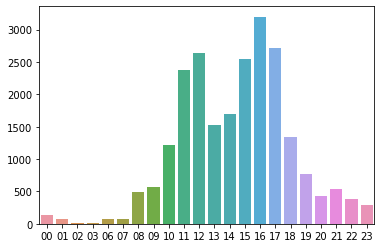

In [112]:
date_only = join_df['date_captured'].tolist()
time_check = dict()
None_count = 0
night_only_one = 0
for idx, date_ in enumerate(date_only):
    if date_ == None:
        None_count += 1
        continue
    hour = date_.split(' ')[1][:2] # 시간만 가져옴
    try:
        time_check[hour] += 1
    except:
        time_check[hour] = 1
        if hour == '00': # 10시 하나만 그려보기 위해 챙기자
            night_only_one = idx
        
print(None_count) # 시간 기록이 안된 것 27개

timeList = time_check.items()
timeList = sorted(timeList) 
x, y = zip(*timeList)
x, y = np.array(x), np.array(y)
sns.barplot(x=x, y=y)
plt.show()

In [115]:
print(night_only_one) # 1089
night_image = join_df.iloc[1089]
print(night_image) # 2021-01-01 00:12:36

1089
width                                  1024
height                                 1024
file_name                    train/4603.jpg
license                                   0
flickr_url                             None
coco_url                               None
date_captured           2021-01-01 00:12:36
category_id                               7
area                                1752.96
bbox             [547.3, 179.5, 52.8, 33.2]
iscrowd                                   0
id                                    21915
Name: 4603, dtype: object


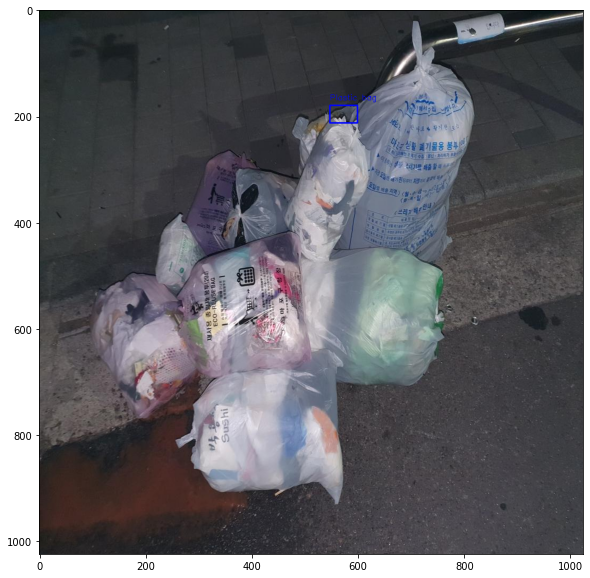

In [116]:
file_name = night_image['file_name']
img_path = file_name
only_bbox_category = night_image[['category_id', 'bbox']].values.tolist()
img = cv2.imread(img_path)

category, bbox = only_bbox_category
cate_class = categories_dict[category]
start_point = (int(bbox[0]), int(bbox[1]))
end_point = (int(bbox[0]) + int(bbox[2]), int(bbox[1]) + int(bbox[3]))
color = color_dict[category]
thickness = 2
img = cv2.rectangle(img, start_point, end_point, color, thickness)
cv2.putText(img, cate_class, (int(bbox[0]), int(bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

/opt/conda/envs/detection/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/envs/detection/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/envs/detection/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 44060 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/conda/envs/detection/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)


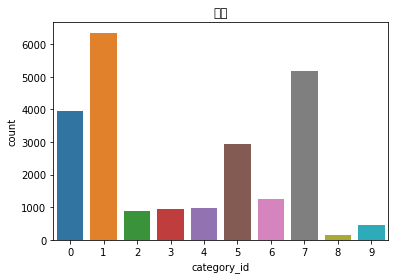

{0: 'General trash', 1: 'Paper', 2: 'Paper pack', 3: 'Metal', 4: 'Glass', 5: 'Plastic', 6: 'Styrofoam', 7: 'Plastic bag', 8: 'Battery', 9: 'Clothing'}


In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="category_id", data=join_df)
plt.title("개수")
plt.show()

categories_dict=dict()
categories_dict = {i['id'] : i['name'] for i in json_data['categories']}
print(categories_dict)

In [61]:
count_bbox = df_annotations['image_id'].value_counts()
print(count_bbox.head(5))  # 이미지당 bbox 개수 Top 5

4197    71
946     55
4047    52
394     48
2981    46
Name: image_id, dtype: int64


In [62]:
# 71개의 bbox를 가진 4197번 이미지 확인
many_bbox_image = join_df.loc['4197']
print(len(many_bbox_image))
print(many_bbox_image.columns)

71
Index(['width', 'height', 'file_name', 'license', 'flickr_url', 'coco_url',
       'date_captured', 'category_id', 'area', 'bbox', 'iscrowd', 'id'],
      dtype='object')


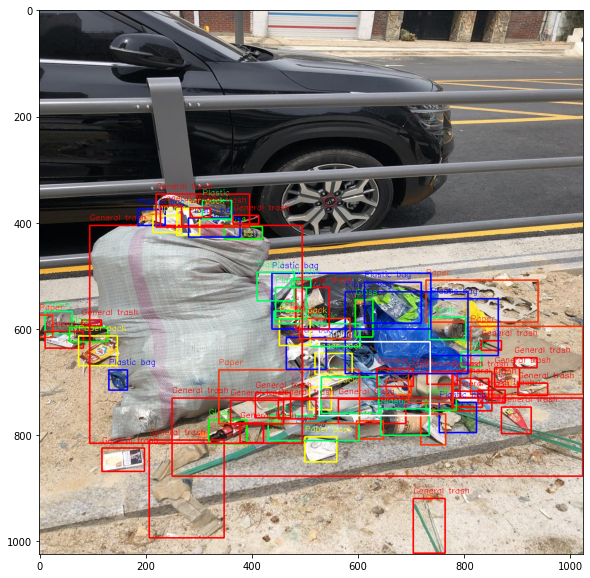

In [63]:
file_name = many_bbox_image['file_name'].unique()
if len(file_name) != 1:
    raise Exception('이미지 1개가 아닌데?') # 유효성 검사
img_path = file_name[0]
only_bbox_category = many_bbox_image[['category_id', 'bbox']].values.tolist()
img = cv2.imread(img_path)
color_dict = {0:(0,0,255), 1:(0,50,255), 2:(0,255,255), 3:(0,255,100), 4:(0,255,0), 5:(100,255,0), 6:(255,0,0), 7:(255,5,0), 8:(255,0,100), 9:(255,255,255)}
for category, bbox in only_bbox_category:
    cate_class = categories_dict[category]
    start_point = (int(bbox[0]), int(bbox[1]))
    end_point = (int(bbox[0]) + int(bbox[2]), int(bbox[1]) + int(bbox[3]))
    color = color_dict[category]
    thickness = 2
    img = cv2.rectangle(img, start_point, end_point, color, thickness)
    cv2.putText(img, cate_class, (int(bbox[0]), int(bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [64]:
print(count_bbox.tail(5))  # 이미지당 bbox 개수 Bottom 5

3359    1
3357    1
1605    1
1608    1
0       1
Name: image_id, dtype: int64


In [66]:
many_bbox_image = join_df.loc['0'] # 1개짜리 어떻게 생겼는지 확인

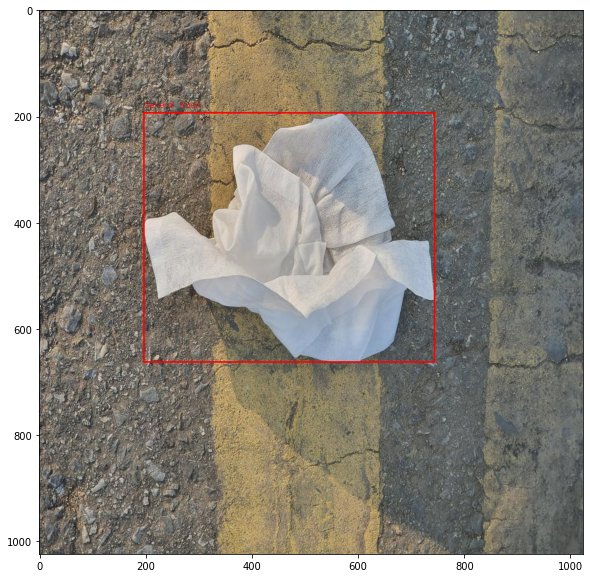

In [67]:
file_name = many_bbox_image['file_name']
img_path = file_name
only_bbox_category = many_bbox_image[['category_id', 'bbox']].values.tolist()
img = cv2.imread(img_path)

category, bbox = only_bbox_category
cate_class = categories_dict[category]
start_point = (int(bbox[0]), int(bbox[1]))
end_point = (int(bbox[0]) + int(bbox[2]), int(bbox[1]) + int(bbox[3]))
color = color_dict[category]
thickness = 2
img = cv2.rectangle(img, start_point, end_point, color, thickness)
cv2.putText(img, cate_class, (int(bbox[0]), int(bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [68]:
    join_df = join_df.sort_values(by=['area']) # 넓이로 정렬
    print(join_df.tail(5)) # 가장 넓은 넓이 확인

      width  height       file_name  license flickr_url coco_url  \
2194   1024    1024  train/2194.jpg        0       None     None   
3289   1024    1024  train/3289.jpg        0       None     None   
1377   1024    1024  train/1377.jpg        0       None     None   
2422   1024    1024  train/2422.jpg        0       None     None   
1160   1024    1024  train/1160.jpg        0       None     None   

            date_captured  category_id        area  \
2194  2020-12-30 11:23:26            0  1048064.06   
3289  2020-12-26 15:05:18            1  1048064.06   
1377  2021-01-09 16:09:14            0  1048064.06   
2422  2020-12-28 15:21:08            0  1048064.06   
1160  2021-01-01 17:59:29            7  1048371.21   

                            bbox  iscrowd     id  
2194  [0.0, 0.0, 1023.8, 1023.7]        0  10443  
3289  [0.0, 0.0, 1023.8, 1023.7]        0  15633  
1377  [0.0, 0.0, 1023.8, 1023.7]        0   6537  
2422  [0.0, 0.0, 1023.7, 1023.8]        0  11449  
1160  [0.0,

In [77]:
max_area_value = join_df.iloc[-1]
print(max_area_value)

width                                  1024
height                                 1024
file_name                    train/1160.jpg
license                                   0
flickr_url                             None
coco_url                               None
date_captured           2021-01-01 17:59:29
category_id                               7
area                             1048371.21
bbox             [0.0, 0.0, 1023.9, 1023.9]
iscrowd                                   0
id                                     5565
Name: 1160, dtype: object


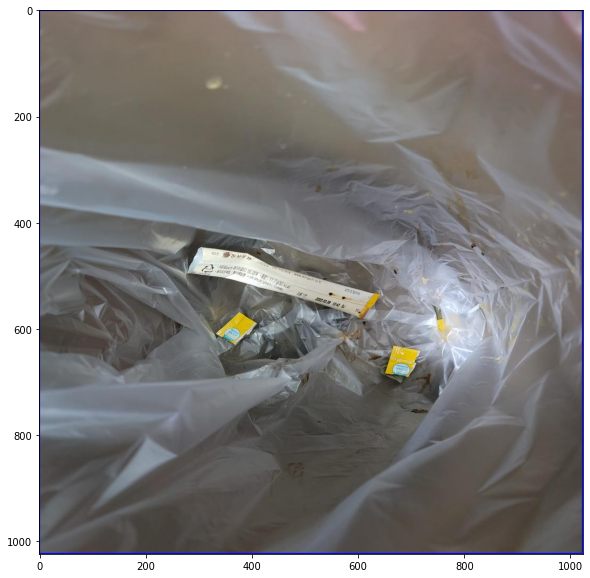

In [78]:
file_name = max_area_value['file_name']
img_path = file_name
only_bbox_category = max_area_value[['category_id', 'bbox']].values.tolist()
img = cv2.imread(img_path)

category, bbox = only_bbox_category
cate_class = categories_dict[category]
start_point = (int(bbox[0]), int(bbox[1]))
end_point = (int(bbox[0]) + int(bbox[2]), int(bbox[1]) + int(bbox[3]))
color = color_dict[category]
thickness = 2
img = cv2.rectangle(img, start_point, end_point, color, thickness)
cv2.putText(img, cate_class, (int(bbox[0]), int(bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [79]:
print(join_df.head(5)) # 면적 하위 5개
min_area_value = join_df.iloc[0]
print(min_area_value)

      width  height       file_name  license flickr_url coco_url  \
1063   1024    1024  train/1063.jpg        0       None     None   
1377   1024    1024  train/1377.jpg        0       None     None   
3712   1024    1024  train/3712.jpg        0       None     None   
1056   1024    1024  train/1056.jpg        0       None     None   
1521   1024    1024  train/1521.jpg        0       None     None   

            date_captured  category_id    area                       bbox  \
1063  2021-04-27 14:26:07            0    0.56   [647.8, 460.2, 0.7, 0.8]   
1377  2021-01-09 16:09:14            1    3.12   [719.8, 604.7, 1.3, 2.4]   
3712  2020-12-28 16:17:48            2   66.25  [883.8, 638.5, 12.5, 5.3]   
1056  2020-12-25 17:05:01            5  105.08   [530.6, 70.9, 14.2, 7.4]   
1521  2021-01-06 17:17:42            3  275.12  [728.4, 307.8, 36.2, 7.6]   

      iscrowd     id  
1063        0   5159  
1377        0   6539  
3712        0  17594  
1056        0   5067  
1521        0

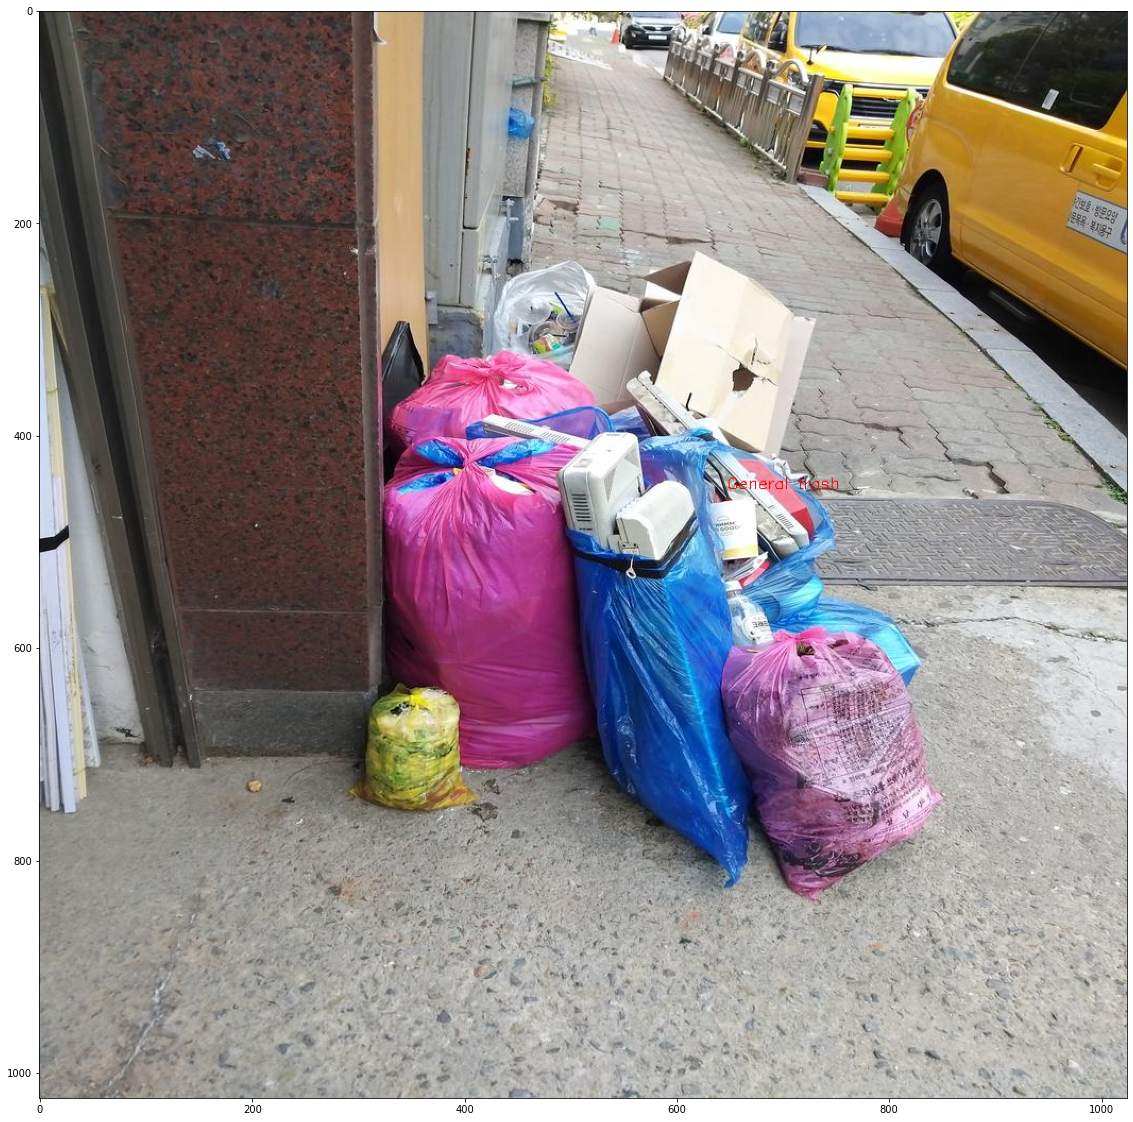

In [81]:
file_name = min_area_value['file_name']
img_path = file_name
only_bbox_category = min_area_value[['category_id', 'bbox']].values.tolist()
img = cv2.imread(img_path)

category, bbox = only_bbox_category
cate_class = categories_dict[category]
start_point = (int(bbox[0]), int(bbox[1]))
end_point = (int(bbox[0]) + int(bbox[2]), int(bbox[1]) + int(bbox[3]))
color = color_dict[category]
thickness = 2
img = cv2.rectangle(img, start_point, end_point, color, thickness)
cv2.putText(img, cate_class, (int(bbox[0]), int(bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

plt.figure(figsize=(20,20))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
import numpy as np
RGB_Mean = np.array([0.48490459, 0.46038158, 0.43166834]) * 255
RGB_Standard = np.array([0.21190031, 0.20929289, 0.21483885]) * 255
print(RGB_Mean)
print(RGB_Standard)

[123.65067045 117.3973029  110.0754267 ]
[54.03457905 53.36968695 54.78390675]
